In [ ]:
!pip install 'u8darts[torch]'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from darts import TimeSeries
from darts.models import TransformerModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import rmse

In [ ]:
# ----------------------------
# 1. Load and Normalize Data
# ----------------------------

# Load ECG signal
data = pd.read_csv("/content/VAISHU_TRAINING.csv", header=None)
signal = data.iloc[:, :-1].values.flatten()

# Normalize
scaler = MinMaxScaler()
signal_scaled = scaler.fit_transform(signal.reshape(-1, 1)).flatten()

In [ ]:
# Create TimeSeries object
start = datetime(2000, 1, 1)
time_index = pd.date_range(start=start, periods=len(signal_scaled), freq='S')
ts = TimeSeries.from_times_and_values(time_index, signal_scaled)

# Create datetime covariates (minute one-hot encoded)
covariates = datetime_attribute_timeseries(time_index, attribute="minute", one_hot=True)

<ipython-input-5-ea8d3730e5c7>:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start=start, periods=len(signal_scaled), freq='S')


In [ ]:
# ----------------------------
# 2. Train-Validation Split
# ----------------------------

input_chunk = 100
output_chunk = 20

train, val = ts[:-1000], ts[-1000:]
cov_train, cov_all = covariates[:-1000], covariates

In [ ]:
# ----------------------------
# 3. Define Transformer Model
# ----------------------------

model = TransformerModel(
    input_chunk_length=input_chunk,
    output_chunk_length=output_chunk,
    batch_size=32,
    n_epochs=10,  # Increase after verifying setup
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dropout=0.3,
    likelihood=GaussianLikelihood(),
    random_state=42
)

pehle main isme 50 run kr rhi thi, fir 20 hone me hi itni der lg gyi toh maine firse start krke 10 pe hi kiya hai

In [ ]:
# ----------------------------
# 4. Train the Model
# ----------------------------

model.fit(series=train, past_covariates=cov_train, verbose=True, epochs=10)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=512, dropout=0.3, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=100, output_chunk_length=20, batch_size=32, n_epochs=10, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, beta_nll=0.0, prior_strength=1.0), random_state=42)

In [ ]:
# ----------------------------
# 5. Forecast & Evaluate
# ----------------------------

forecast = model.predict(n=len(val), past_covariates=cov_all)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

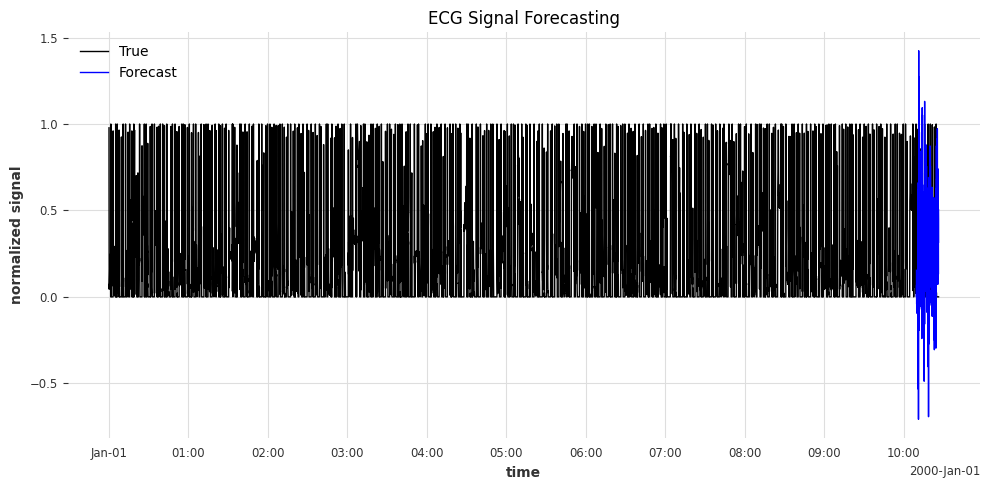

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
ts.plot(label="True", lw=1, color='black')
forecast.plot(label="Forecast", lw=1, color='blue')
plt.title("ECG Signal Forecasting")
plt.xlabel("time")
plt.ylabel("normalized signal")
plt.legend()
plt.tight_layout()
plt.show()


kyuki uper wale me saare points plot hue hain toh bohot hoch poch ho rha hai, toh neeche humne saare points na plot karke kuch hi kiy hain taaki hume trends or direction samajh aaye

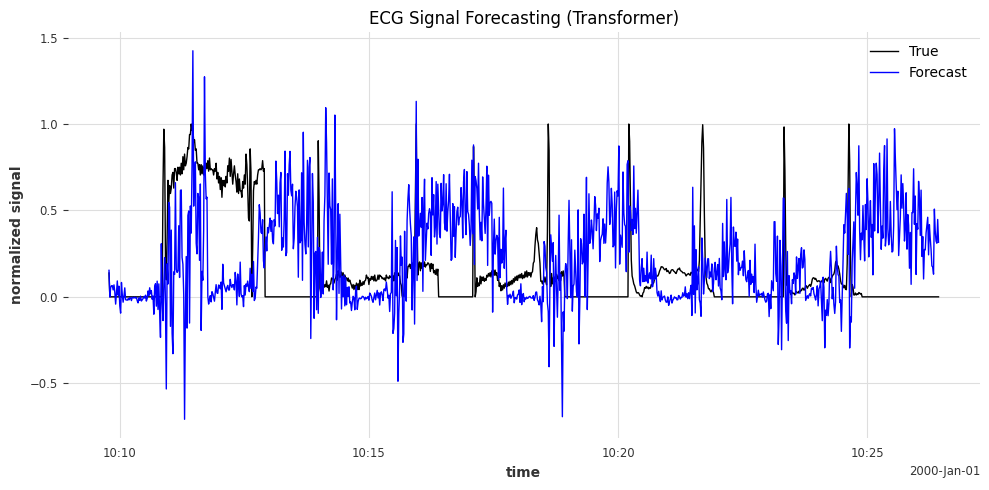

Transformer RMSE: 0.3842


In [ ]:
# Zoomed plot
plt.figure(figsize=(10, 5))
val.plot(label="True", lw=1, color='black')
forecast.plot(label="Forecast", lw=1, color='blue')
plt.title("ECG Signal Forecasting (Transformer)")
plt.xlabel("time")
plt.ylabel("normalized signal")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE
error = rmse(val, forecast)
print(f"Transformer RMSE: {error:.4f}")